In [1]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, models
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, os


d:\CodingPlayground\NLP\Project\env_proj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load QQP dataset (either Kaggle or HuggingFace version)
df = pd.read_csv("train.csv")  # change path if needed
df = df.dropna(subset=['question1', 'question2'])

# Optional subsample for faster fine-tuning
df = df.sample(50000, random_state=42).reset_index(drop=True)

# Split into train/validation
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))


Train size: 40000
Validation size: 10000


In [3]:
train_examples = [
    InputExample(texts=[str(row['question1']), str(row['question2'])], label=float(row['is_duplicate']))
    for _, row in train_df.iterrows()
]

val_examples = [
    InputExample(texts=[str(row['question1']), str(row['question2'])], label=float(row['is_duplicate']))
    for _, row in val_df.iterrows()
]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)


In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [5]:
%pip install -U transformers[torch] accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
train_loss = losses.MultipleNegativesRankingLoss(model)

# Train for 1–3 epochs depending on resources
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=2,
    warmup_steps=int(0.1 * len(train_dataloader)),
    show_progress_bar=True
)

model.save('sbert-finetuned-qqp')


Step,Training Loss
500,0.406900
1000,0.379900
1500,0.332800
2000,0.299500
2500,0.312000


In [8]:
def evaluate_model(model, df, threshold=0.75):
    q1_embeddings = model.encode(df['question1'].tolist(), batch_size=64, convert_to_tensor=True)
    q2_embeddings = model.encode(df['question2'].tolist(), batch_size=64, convert_to_tensor=True)

    cosine_scores = torch.nn.functional.cosine_similarity(q1_embeddings, q2_embeddings)
    preds = (cosine_scores > threshold).cpu().numpy().astype(int)
    y_true = df['is_duplicate'].values

    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}")
    print(classification_report(y_true, preds))
    return preds, cosine_scores

preds, scores = evaluate_model(model, val_df)


Accuracy: 0.7522 | F1: 0.7105
              precision    recall  f1-score   support

           0       0.86      0.72      0.78      6205
           1       0.64      0.80      0.71      3795

    accuracy                           0.75     10000
   macro avg       0.75      0.76      0.75     10000
weighted avg       0.77      0.75      0.76     10000



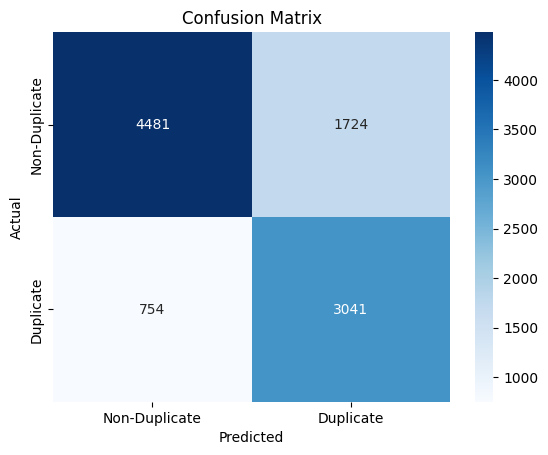

In [9]:
cm = confusion_matrix(val_df['is_duplicate'], preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Duplicate','Duplicate'], yticklabels=['Non-Duplicate','Duplicate'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
val_df['pred'] = preds
val_df['score'] = scores.cpu().numpy()

false_pos = val_df[(val_df['is_duplicate']==0) & (val_df['pred']==1)].head(10)
false_neg = val_df[(val_df['is_duplicate']==1) & (val_df['pred']==0)].head(10)

print("False Positives (Predicted Duplicate but Not):")
display(false_pos[['question1','question2','score']])

print("\nFalse Negatives (Missed Duplicates):")
display(false_neg[['question1','question2','score']])


False Positives (Predicted Duplicate but Not):


,question1,question2,score
36958,Is there a Drug and Alcohol Rehab Center in Di...,Is there a Drug and Alcohol Rehab Center in Ko...,0.847971
12144,Where is Mount Villarica located and how does ...,Where is Mount Villarica located and how does ...,0.881170
821,Which are some of the best YouTube channels to...,Which is the best YouTube Channel you ever sub...,0.910958
42111,What are the most famous/popular local product...,What are the most famous/popular local product...,0.811702
5503,What is the chemical reaction when acetic acid...,What is the reaction between acetic acid and s...,0.906588
3918,What is the history of the Glassboro train sta...,What is the history of the Glassboro train sta...,0.922286
14644,Would it be a good idea to visit Rajasthan in ...,Would it be a good idea to visit Rajasthan?,0.877330
42684,Why is the circle an important Apache tribe sy...,Why is the feather an important Apache tribe s...,0.866146
44305,Why is my fudge not melting?,How do you melt fudge?,0.818938
36056,What colour top should I wear with a beige col...,What colour of tops I should wear with yellow ...,0.849084



False Negatives (Missed Duplicates):


,question1,question2,score
39489,How is hiroshima now?,What is it like to live in the cities of Hiros...,0.731486
12609,Why is Manaphy very ugly in Pokémon Ranger and...,Why is Manaphy an ugly baby pokemon in the movie?,0.723088
49717,Is it possible to fall in love with more than ...,Is it possible for people to love 2 person at ...,0.675080
9413,How can I Ignore negative thoughts?,How do I overcome negative thoughts? How to ov...,0.733816
41252,How do I forget someone whom l love so much?,How do I unlove someone whom I love deeply?,0.696164
3850,Why do people ask question on Quora that can b...,Why do people use Quora when they could easily...,0.727847
15267,What are some of the criticisms of NAFTA?,What are the worst consequences of NAFTA?,0.662311
26803,What would happen if I sent two private invest...,What if I hired two private eyes and ordered t...,0.641472
36537,Why did Bernie Sanders lose to Hillary Clinton?,Why did the USA choose Hillary Clinton over Be...,0.746955
33704,Is it possible to remain friends with an ex th...,Is it possible to stay friends with your ex wi...,0.675419


In [11]:
# Generate embeddings for a random subset
sample_nondupes = train_df[train_df['is_duplicate']==0].sample(2000, random_state=42)
q1_emb = model.encode(sample_nondupes['question1'].tolist(), convert_to_tensor=True)
q2_emb = model.encode(sample_nondupes['question2'].tolist(), convert_to_tensor=True)

# Find most semantically similar non-duplicate pairs (hard negatives)
cos_sim = torch.nn.functional.cosine_similarity(q1_emb, q2_emb)
hard_neg_indices = torch.topk(cos_sim, k=200, largest=True).indices.cpu().numpy()
hard_negatives = sample_nondupes.iloc[hard_neg_indices]

print("Top 5 hard negatives:")
display(hard_negatives[['question1','question2']].head())


Top 5 hard negatives:


,question1,question2
8816,Which was the first novel?,What was the first novel?
5463,Why is Kim Grimes the most inspirational leade...,Is Kim Grimes the most inspirational leader in...
10174,I am expecting 240 marks in the JEE Mains pape...,I am expecting 240 marks in the JEE Mains pape...
39078,How do I do this maths problem?,How do I do this math problem?
38727,How can I make a video like this?,How do I make a video like this?


In [12]:
from sentence_transformers.losses import TripletLoss

# Prepare triplets (anchor, positive, negative)
triplets = []
for _, row in train_df[train_df['is_duplicate']==1].sample(2000, random_state=42).iterrows():
    anchor = str(row['question1'])
    positive = str(row['question2'])
    negative = str(random.choice(hard_negatives['question2'].tolist()))
    triplets.append(InputExample(texts=[anchor, positive, negative]))

triplet_dataloader = DataLoader(triplets, shuffle=True, batch_size=16)
triplet_loss = TripletLoss(model)

model.fit(train_objectives=[(triplet_dataloader, triplet_loss)], epochs=1, show_progress_bar=True)
model.save('sbert-hardneg-qqp')


d:\CodingPlayground\NLP\Project\env_proj\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


In [13]:
print("Baseline SBERT Fine-tuned Results:")
evaluate_model(SentenceTransformer('sbert-finetuned-qqp'), val_df)

print("\nAfter Hard-Negative Mining:")
evaluate_model(SentenceTransformer('sbert-hardneg-qqp'), val_df)


Baseline SBERT Fine-tuned Results:
Accuracy: 0.7522 | F1: 0.7105
              precision    recall  f1-score   support

           0       0.86      0.72      0.78      6205
           1       0.64      0.80      0.71      3795

    accuracy                           0.75     10000
   macro avg       0.75      0.76      0.75     10000
weighted avg       0.77      0.75      0.76     10000


After Hard-Negative Mining:
Accuracy: 0.7513 | F1: 0.7083
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      6205
           1       0.64      0.80      0.71      3795

    accuracy                           0.75     10000
   macro avg       0.75      0.76      0.75     10000
weighted avg       0.77      0.75      0.75     10000



(array([1, 1, 0, ..., 0, 0, 0], shape=(10000,)),
 tensor([0.9584, 0.7652, 0.1615,  ..., 0.6644, 0.6696, 0.6874]))

In [14]:
val_df[['question1','question2','is_duplicate','pred','score']].to_csv('qqp_final_predictions.csv', index=False)
